In [1]:
import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss

In [2]:
#Working directory
# ct='Can tintorer'
# pcm='Encinsasola'
#ct = pd.read_excel('./XRF_DASA_trainning_duplicado_copia.xlsx',sheet_name='ct', engine='openpyxl')
#pcm = pd.read_excel('./DATA/XRF_DASA_trainning_duplicado_copia.xlsx',sheet_name='pcm', engine='openpyxl') 
df = pd.read_excel('./DATA/XRF_DASA_trainning_duplicado_copia.xlsx',sheet_name='pldc', engine='openpyxl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 51 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Site         1816 non-null   object 
 1   target_PDLC  1816 non-null   int64  
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   0 non-null      float64
 4   Contexto     1805 non-null   object 
 5   Mg           1816 non-null   float64
 6   Al           1816 non-null   float64
 7   Si           1816 non-null   float64
 8   P            1816 non-null   float64
 9   S            1816 non-null   float64
 10  Cl           1816 non-null   float64
 11  K            1816 non-null   float64
 12  Ca           1816 non-null   float64
 13  Sc           1816 non-null   float64
 14  Ti           1816 non-null   float64
 15  V            1816 non-null   float64
 16  Cr           1816 non-null   float64
 17  Mn           1816 non-null   float64
 18  Fe           1816 non-null   float64
 19  Co    

In [3]:
# Eliminamos columnas innecesarias para nuestro experimiento
#Some basic Feature engineering
df = df.drop(['Site','Unnamed: 2', 'Unnamed: 3', 'Contexto', 'suma'], axis=1)
#Comprobamos que no hay valores faltantes
# Checking missing values
df.isnull().any().any()


False

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target_PDLC  1816 non-null   int64  
 1   Mg           1816 non-null   float64
 2   Al           1816 non-null   float64
 3   Si           1816 non-null   float64
 4   P            1816 non-null   float64
 5   S            1816 non-null   float64
 6   Cl           1816 non-null   float64
 7   K            1816 non-null   float64
 8   Ca           1816 non-null   float64
 9   Sc           1816 non-null   float64
 10  Ti           1816 non-null   float64
 11  V            1816 non-null   float64
 12  Cr           1816 non-null   float64
 13  Mn           1816 non-null   float64
 14  Fe           1816 non-null   float64
 15  Co           1816 non-null   float64
 16  Ni           1816 non-null   float64
 17  Cu           1816 non-null   float64
 18  Zn           1816 non-null   float64
 19  Ga    

In [5]:
# Distribución en el target_Group
# More Exploratory Analysis
df = df.rename(columns={'target_PDLC': 'target'})
target = df['target'].value_counts()
target

target
0    1305
1     511
Name: count, dtype: int64

In [6]:
X = df.drop(['target'], axis=1)
y = df['target']

In [7]:
# 1. Primera división
X_dev, X_final_val, y_dev, y_final_val = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=42, 
    stratify=y
)

# 2. División para calibración
X_train_base, X_calib, y_train_base, y_calib = train_test_split(
    X_dev, y_dev,
    test_size=0.2,
    random_state=42,
    stratify=y_dev
)

# 3. Aplicar SMOTE solo a datos de entrenamiento base
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_base)



target
0    939
1    939
Name: count, dtype: int64

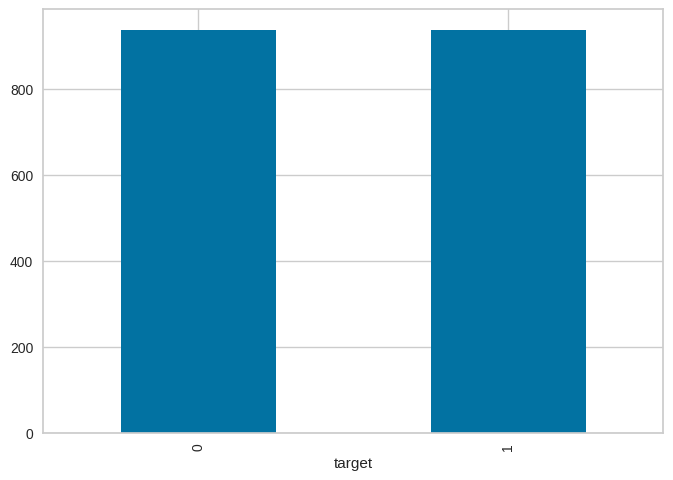

In [8]:
y_train_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_train_smote.value_counts()

In [9]:

# 4. Entrenar modelo base
rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, class_weight="balanced", criterion='entropy')
rf_model.fit(X_train_smote, y_train_smote)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=5, n_estimators=200)

In [10]:

# Asumiendo que ya tienes tu modelo entrenado
plattcalibrator = CalibratedClassifierCV(rf_model, cv='prefit', method='sigmoid')
isotonicalibrator = CalibratedClassifierCV(rf_model, cv='prefit', method='isotonic')
plattcalibrator.fit(X_calib, y_calib)
isotonicalibrator.fit(X_calib, y_calib)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        min_samples_leaf=5,
                                                        n_estimators=200),
                       method='isotonic')

In [12]:
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

def compute_scores(y_true, y_pred_proba, name=None):
    """Compute a specific set of classification scores."""    
    scores = {
        'brier_score': brier_score_loss(y_true, y_pred_proba),
        'log_loss_score': log_loss(y_true, y_pred_proba),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    return pd.Series(scores).rename(name)

# Obtener predicciones del modelo original y calibrados
prob_pred_original = rf_model.predict_proba(X_final_val)[:, 1]

# Crear y entrenar calibradores
platt_calibrator = CalibratedClassifierCV(rf_model, cv='prefit', method='sigmoid')
isot_calibrator = CalibratedClassifierCV(rf_model, cv='prefit', method='isotonic')

# Ajustar usando conjunto de calibración
platt_calibrator.fit(X_calib, y_calib)
isot_calibrator.fit(X_calib, y_calib)

# Obtener predicciones calibradas
prob_pred_platt = platt_calibrator.predict_proba(X_final_val)[:, 1]
prob_pred_isot = isot_calibrator.predict_proba(X_final_val)[:, 1]

# Computar y mostrar métricas
df_scores = pd.DataFrame([
    compute_scores(y_final_val, prob_pred_original, name='Uncalibrated'),
    compute_scores(y_final_val, prob_pred_platt, name='Platt Scaling'),
    compute_scores(y_final_val, prob_pred_isot, name='Isotonic Regression')
])

# Formatear la salida para mejor visualización
print(df_scores.round(6))

                     brier_score  log_loss_score   roc_auc
Uncalibrated            0.037744        0.152037  0.994612
Platt Scaling           0.028188        0.092762  0.994612
Isotonic Regression     0.028943        0.271947  0.991468


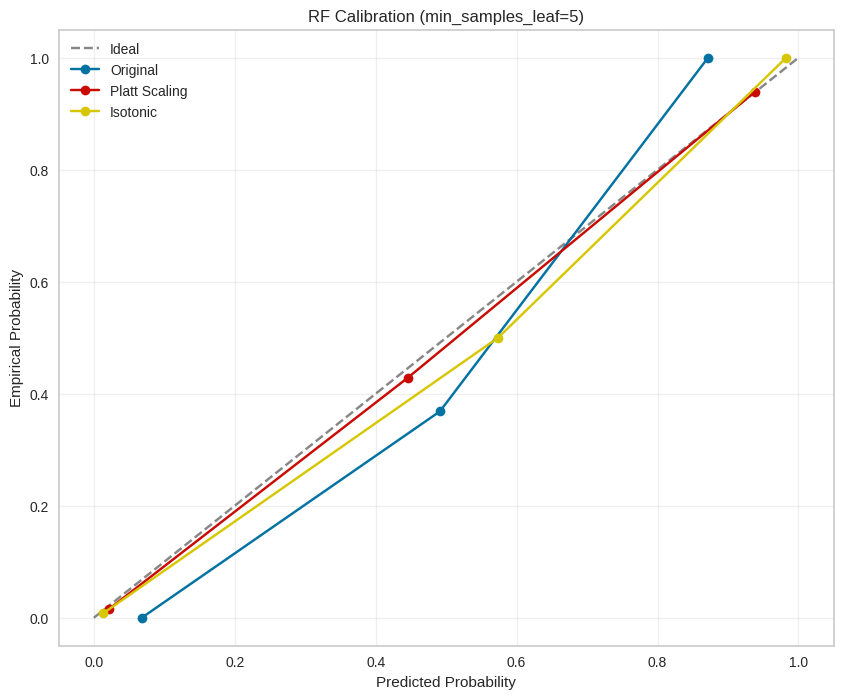


Results for min_samples_leaf=5
AUC-ROC - Original: 0.995, Platt: 0.995, Isotonic: 0.995
F1-Score - Original: 0.923, Platt: 0.922, Isotonic: 0.926
Brier Score - Original: 0.037, Platt: 0.027, Isotonic: 0.025
Log Loss - Original: 0.152, Platt: 0.088, Isotonic: 0.078


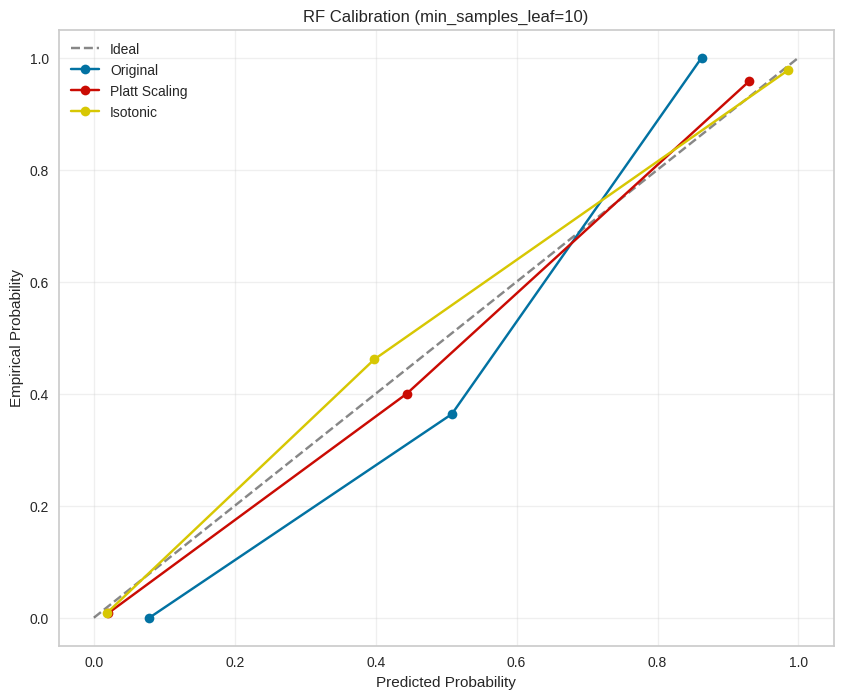


Results for min_samples_leaf=10
AUC-ROC - Original: 0.995, Platt: 0.995, Isotonic: 0.995
F1-Score - Original: 0.933, Platt: 0.902, Isotonic: 0.917
Brier Score - Original: 0.042, Platt: 0.027, Isotonic: 0.026
Log Loss - Original: 0.170, Platt: 0.093, Isotonic: 0.080


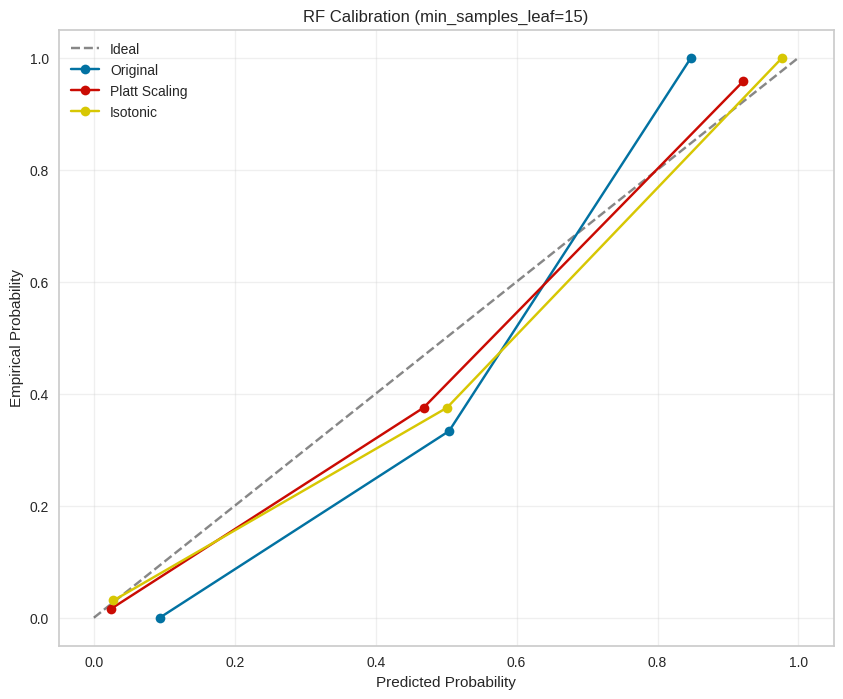


Results for min_samples_leaf=15
AUC-ROC - Original: 0.995, Platt: 0.995, Isotonic: 0.994
F1-Score - Original: 0.916, Platt: 0.902, Isotonic: 0.929
Brier Score - Original: 0.046, Platt: 0.028, Isotonic: 0.028
Log Loss - Original: 0.185, Platt: 0.096, Isotonic: 0.087


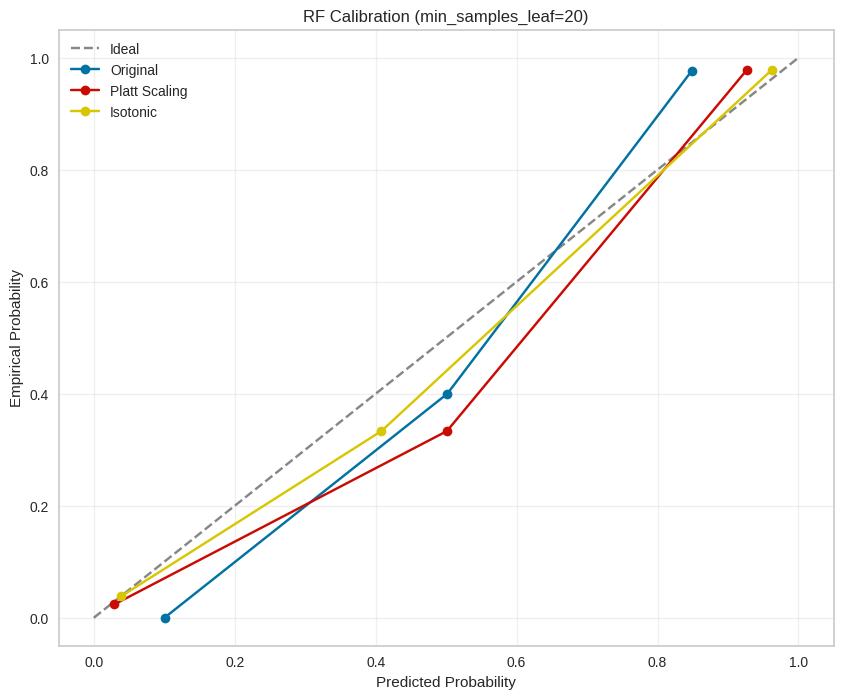


Results for min_samples_leaf=20
AUC-ROC - Original: 0.993, Platt: 0.993, Isotonic: 0.993
F1-Score - Original: 0.906, Platt: 0.902, Isotonic: 0.917
Brier Score - Original: 0.050, Platt: 0.031, Isotonic: 0.030
Log Loss - Original: 0.199, Platt: 0.104, Isotonic: 0.095


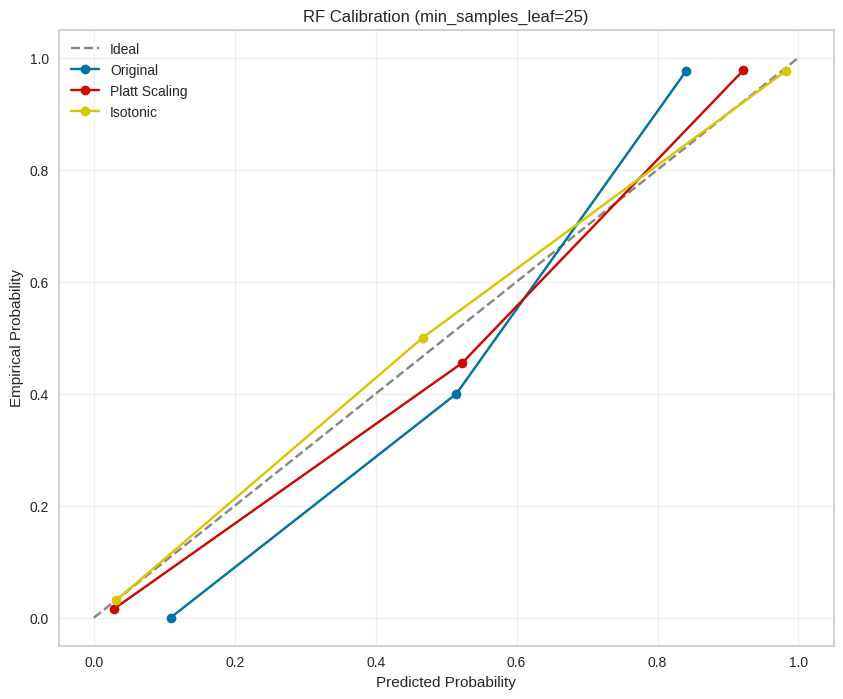


Results for min_samples_leaf=25
AUC-ROC - Original: 0.994, Platt: 0.994, Isotonic: 0.992
F1-Score - Original: 0.916, Platt: 0.893, Isotonic: 0.894
Brier Score - Original: 0.053, Platt: 0.031, Isotonic: 0.032
Log Loss - Original: 0.209, Platt: 0.106, Isotonic: 0.097


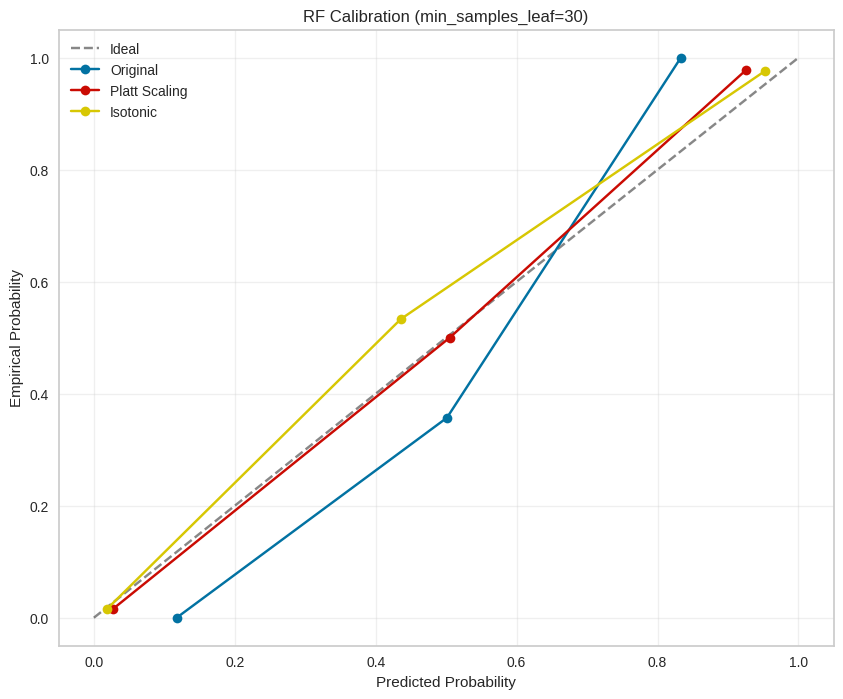


Results for min_samples_leaf=30
AUC-ROC - Original: 0.993, Platt: 0.993, Isotonic: 0.992
F1-Score - Original: 0.916, Platt: 0.902, Isotonic: 0.917
Brier Score - Original: 0.056, Platt: 0.031, Isotonic: 0.034
Log Loss - Original: 0.221, Platt: 0.106, Isotonic: 0.105

Summary:
   leaf_size  auc_orig  auc_platt  auc_isot  f1_orig  f1_platt  f1_isot  \
0          5    0.9952     0.9952    0.9952   0.9231    0.9216   0.9259   
1         10    0.9954     0.9954    0.9948   0.9333    0.9020   0.9167   
2         15    0.9949     0.9949    0.9940   0.9159    0.9020   0.9293   
3         20    0.9930     0.9930    0.9930   0.9057    0.9020   0.9167   
4         25    0.9936     0.9936    0.9921   0.9159    0.8932   0.8936   
5         30    0.9934     0.9934    0.9920   0.9159    0.9020   0.9167   

   brier_orig  brier_platt  brier_isot  log_loss_orig  log_loss_platt  \
0      0.0374       0.0267      0.0254         0.1522          0.0884   
1      0.0422       0.0274      0.0260         0.17

In [13]:
# min_samples_leaf values
leaf_values = [5, 10, 15, 20, 25, 30]
results = []

for leaf_size in leaf_values:
    # Crear y entrenar modelo con datos de entrenamiento SMOTE
    rf = RandomForestClassifier(
        n_estimators=200, 
        min_samples_leaf=leaf_size, 
        class_weight="balanced",
        criterion='entropy',
        random_state=42
    )
    rf.fit(X_train_smote, y_train_smote)
    
    # Calibrate using calibration subset
    platt_calibrator = CalibratedClassifierCV(rf, cv='prefit', method='sigmoid')
    isot_calibrator = CalibratedClassifierCV(rf, cv='prefit', method='isotonic')
    
    platt_calibrator.fit(X_calib, y_calib)
    isot_calibrator.fit(X_calib, y_calib)
    
    # Predictions on final validation subset
    y_prob_orig = rf.predict_proba(X_final_val)[:, 1]
    y_prob_platt = platt_calibrator.predict_proba(X_final_val)[:, 1]
    y_prob_isot = isot_calibrator.predict_proba(X_final_val)[:, 1]
    
    # Metrics calculations
    metrics = {
        'leaf_size': leaf_size,
        'auc_orig': roc_auc_score(y_final_val, y_prob_orig),
        'auc_platt': roc_auc_score(y_final_val, y_prob_platt),
        'auc_isot': roc_auc_score(y_final_val, y_prob_isot),
        'f1_orig': f1_score(y_final_val, rf.predict(X_final_val)),
        'f1_platt': f1_score(y_final_val, platt_calibrator.predict(X_final_val)),
        'f1_isot': f1_score(y_final_val, isot_calibrator.predict(X_final_val)),
        'brier_orig': brier_score_loss(y_final_val, y_prob_orig),
        'brier_platt': brier_score_loss(y_final_val, y_prob_platt),
        'brier_isot': brier_score_loss(y_final_val, y_prob_isot),
        'log_loss_orig': log_loss(y_final_val, y_prob_orig),
        'log_loss_platt': log_loss(y_final_val, y_prob_platt),
        'log_loss_isot': log_loss(y_final_val, y_prob_isot)
    }
    results.append(metrics)
    
    # Calibration curve plot
    plt.figure(figsize=(10, 8))
    
    # Calibration curve calculations
    prob_true_orig, prob_pred_orig = calibration_curve(y_final_val, y_prob_orig, n_bins=3)
    prob_true_platt, prob_pred_platt = calibration_curve(y_final_val, y_prob_platt, n_bins=3)
    prob_true_isot, prob_pred_isot = calibration_curve(y_final_val, y_prob_isot, n_bins=3)
    
    # Plot
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal', alpha=0.5)
    plt.plot(prob_pred_orig, prob_true_orig, 'b-o', label='Original')
    plt.plot(prob_pred_platt, prob_true_platt, 'r-o', label='Platt Scaling')
    plt.plot(prob_pred_isot, prob_true_isot, 'y-o', label='Isotonic')
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title(f'RF Calibration (min_samples_leaf={leaf_size})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()
    
    # Metrics
    print(f"\nResults for min_samples_leaf={leaf_size}")
    print(f"AUC-ROC - Original: {metrics['auc_orig']:.3f}, "
          f"Platt: {metrics['auc_platt']:.3f}, "
          f"Isotonic: {metrics['auc_isot']:.3f}")
    print(f"F1-Score - Original: {metrics['f1_orig']:.3f}, "
          f"Platt: {metrics['f1_platt']:.3f}, "
          f"Isotonic: {metrics['f1_isot']:.3f}")
    print(f"Brier Score - Original: {metrics['brier_orig']:.3f}, "
          f"Platt: {metrics['brier_platt']:.3f}, "
          f"Isotonic: {metrics['brier_isot']:.3f}")
    print(f"Log Loss - Original: {metrics['log_loss_orig']:.3f}, "
          f"Platt: {metrics['log_loss_platt']:.3f}, "
          f"Isotonic: {metrics['log_loss_isot']:.3f}")

# Outputs to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nSummary:")
print(results_df.round(4))